# Preferential Attachment Analysis

Here we analyze preferential attachment in fine-tuning. We treat each attachment as a 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import random

# Load the data
G = pickle.load(open('data/ai_ecosystem_graph_finetune.pkl', 'rb'))

In [2]:

# Get a random node from G and print all its information
node = random.choice(list(G.nodes))
print(G.nodes[node])

{'likes': 0, 'downloads': 2, 'pipeline_tag': nan, 'library_name': nan, 'createdAt': '2024-08-15T18:50:44.000Z', 'licenses': "['other']", 'datasets': '[]', 'languages': '[]'}


In [3]:

from datetime import datetime

# Convert the 'createdAt' attribute to a datetime object for each node
for node in G.nodes:
    G.nodes[node]['createdAt'] = datetime.strptime(G.nodes[node]['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')

# Get the current time
current_time = datetime.now()

# Filter nodes that have been created
created_nodes = [node for node in G.nodes if G.nodes[node]['createdAt'] <= current_time]

# Initialize a dictionary to count attachments by degree
degree_attachment_count = {}

# Iterate over each edge in the graph
counter = 0
for u, v in G.edges:
    # Check if both nodes are in the created_nodes list
    if u in created_nodes and v in created_nodes:
        counter += 1
        if counter % 100 == 0:
            print(f"Processed {counter} edges")
        # Get the degree of the nodes
        degree_u = G.degree[u]
        degree_v = G.degree[v]
        
        # Increment the attachment count for each degree
        if degree_u not in degree_attachment_count:
            degree_attachment_count[degree_u] = 0
        if degree_v not in degree_attachment_count:
            degree_attachment_count[degree_v] = 0
        
        degree_attachment_count[degree_u] += 1
        degree_attachment_count[degree_v] += 1




KeyboardInterrupt: 

In [20]:
# Calculate the probability of attachment for each degree
total_attachments = sum(degree_attachment_count.values())
probability_of_attachment = {degree: count / total_attachments for degree, count in degree_attachment_count.items()}

# Print the probability of attachment for each degree
print(probability_of_attachment)

{2: 0.008088235294117648, 1: 0.48504901960784313, 7: 0.0014705882352941176, 10: 0.004656862745098039, 18: 0.004411764705882353, 4: 0.003431372549019608, 6: 0.00196078431372549, 22: 0.005147058823529412, 15: 0.0004901960784313725, 441: 0.10808823529411765, 53: 0.012990196078431373, 1576: 0.35784313725490197, 9: 0.0004901960784313725, 39: 0.00024509803921568627, 864: 0.00024509803921568627, 3: 0.0029411764705882353, 5: 0.0022058823529411764, 32: 0.00024509803921568627}


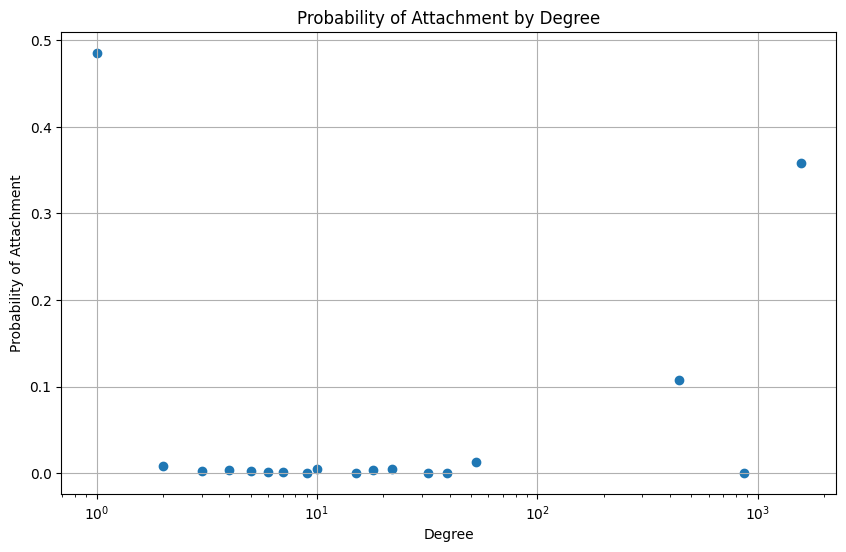

In [24]:
import matplotlib.pyplot as plt

# Plot the probability of attachment
degrees = list(probability_of_attachment.keys())
probabilities = list(probability_of_attachment.values())

plt.figure(figsize=(10, 6))
plt.scatter(degrees, probabilities, marker='o')
plt.xscale('log')
plt.title('Probability of Attachment by Degree')
plt.xlabel('Degree')
plt.ylabel('Probability of Attachment')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from scipy.optimize import minimize
from collections import Counter


# Define the likelihood function for the conditional logit model
def likelihood(params, chosen_indices, feature_matrix, k_values, delta):
    alpha, beta = params[0], params[1:]
    chosen_utilities = (k_values[chosen_indices] + delta) ** alpha * np.exp(np.dot(feature_matrix[chosen_indices], beta))
    all_utilities = (k_values + delta) ** alpha * np.exp(np.dot(feature_matrix, beta))
    
    # Calculate the log-likelihood
    log_likelihood = np.sum(np.log(chosen_utilities / np.sum(all_utilities, axis=1)))
    return -log_likelihood  # We minimize, so return negative log-likelihood

# Sample a few non-chosen candidates per event
def sample_non_chosen(chosen_indices, num_samples, total_candidates):
    non_chosen_samples = []
    for chosen in chosen_indices:
        candidates = list(range(total_candidates))
        candidates.remove(chosen)
        sampled = np.random.choice(candidates, num_samples, replace=False)
        non_chosen_samples.append(sampled)
    return np.array(non_chosen_samples)

# Example data setup
num_events = 1000
#num_features = 7
#num_candidates = 10
delta = 0.1

# Extract the 'license' feature and k values from the graph G
license_feature = []
k_values = []

# Top-5 licneses
list_all_licenses = []

for node in G.nodes(data=True):
    list_all_licenses.append(node[1].get('licenses', 'unknown'))

top_5_licenses = Counter(list_all_licenses).most_common(5)

for node in G.nodes(data=True):
    license_i = node[1].get('licenses', 'unknown')
    if license_i in [x[0] for x in top_5_licenses]:
        license_feature.append(license_i)  # Default to 'other' if 'license' is not present
    else:
        license_feature.append('other')
    k_values.append(G.degree(node[0]))

# Convert the license feature to a categorical feature matrix
unique_licenses = list(set(license_feature))
license_to_index = {license: idx for idx, license in enumerate(unique_licenses)}
feature_matrix = np.zeros((len(license_feature), len(unique_licenses)))

for i, license in enumerate(license_feature):
    feature_matrix[i, license_to_index[license]] = 1

# Randomly choose indices for chosen candidates
chosen_indices = np.random.choice(len(license_feature), num_events)

# Sample non-chosen candidates
non_chosen_samples = sample_non_chosen(chosen_indices, 3, len(license_feature))

# Initial parameter guess
initial_params = np.zeros(len(unique_licenses) + 1)  # alpha + beta

# Optimize the likelihood function
def likelihood(params, chosen_indices, feature_matrix, k_values, delta):
    alpha = params[0]
    beta = params[1:]

    # Adjust k_values to handle zero-degree issue
    adjusted_k_values = adjust_k_values(k_values, k0=1.0)
    
    # Calculate utilities for all candidates
    all_utilities = (k_values + delta) ** alpha * np.exp(np.dot(feature_matrix, beta))
    
    # Calculate utilities for chosen candidates
    chosen_utilities = all_utilities[chosen_indices]
    
    # Calculate log likelihood
    if all_utilities.ndim == 1:
        log_likelihood = np.sum(np.log(chosen_utilities / np.sum(all_utilities)))
    else:
        log_likelihood = np.sum(np.log(chosen_utilities / np.sum(all_utilities, axis=1)))
    
    return -log_likelihood

# Use the likelihood function in the optimization
result = minimize(likelihood, initial_params, args=(chosen_indices, feature_matrix, np.array(k_values), delta), method='BFGS')

# Extract the estimated parameters
estimated_alpha = result.x[0]
estimated_beta = result.x[1:]

print(f"Estimated alpha: {estimated_alpha}")
print(f"Estimated beta: {estimated_beta}")



Estimated alpha: -0.027752160834440726
Estimated beta: [ 0.01606616 -0.02041596 -0.26310036  0.15996113  0.05909069  0.04846299]


In [11]:
# Define a function to handle zero-degree issue
def adjust_k_values(k_values, k0=1.0):
    """
    Adjust k_values to handle zero-degree issue by adding a small constant k0.
    
    Parameters:
    - k_values: array-like, original degree values
    - k0: float, small constant to add to k_values to avoid zero-degree issue
    
    Returns:
    - adjusted_k_values: array-like, adjusted degree values
    """
    return k_values + k0

# Adjust k_values before using them in the likelihood function
adjusted_k_values = adjust_k_values(np.array(k_values), k0=1.0)

# Use the adjusted k_values in the optimization
result = minimize(likelihood, initial_params, args=(chosen_indices, feature_matrix, adjusted_k_values, delta), method='BFGS')

# Extract the estimated parameters
estimated_alpha = result.x[0]
estimated_beta = result.x[1:]

print(f"Estimated alpha: {estimated_alpha}")
print(f"Estimated beta: {estimated_beta}")


Estimated alpha: -0.07795381041433165
Estimated beta: [ 0.01705435 -0.02243148 -0.26078576  0.15912289  0.05999967  0.05025913]


In [12]:
top_5_licenses

[('[]', 1188829),
 ("['apache-2.0']", 298247),
 ("['mit']", 109769),
 ("['other']", 81868),
 ("['openrail']", 37489)]

In [8]:
# The error indicates that the array `all_utilities` is one-dimensional, but the code is trying to sum over axis 1.
# To fix this, ensure that `all_utilities` is a two-dimensional array or adjust the axis parameter.

# Check the shape of all_utilities
all_utilities = (k_values + delta) ** alpha * np.exp(np.dot(feature_matrix, beta))

# If all_utilities is indeed one-dimensional, sum over axis 0 instead
if all_utilities.ndim == 1:
    log_likelihood = np.sum(np.log(chosen_utilities / np.sum(all_utilities)))
else:
    log_likelihood = np.sum(np.log(chosen_utilities / np.sum(all_utilities, axis=1)))

return -log_likelihood


TypeError: can only concatenate list (not "float") to list